In [29]:
from unet import *
import functions
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.optim as optim
from tqdm import trange
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import pandas as pd
import scipy.io
# tensor summary import
from torchsummary import summary

In [30]:
Net = build_unet()
# check if CUDA is available, and set it as the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("==> Device: {}".format(device))

# move model to the device
Net.to(device)

# define loss function
#loss_function = nn.MSELoss()
loss_function = nn.L1Loss()

####### HYPERPARAMETERS #######

# learning rate = 10^-4
lr = 0.0001

# patch size
patch_size = 512

# define optimizer
optimizer = optim.Adam(Net.parameters(), lr=lr)

# batch size
batch_size = 1

# define number of epochs
n_epochs = 100

# keep track of the best validation loss
valid_loss_min = np.Inf

# number of epochs to wait before stopping
early_stopping = 5


##### LOSS  #######

# keep track of training and validation loss
train_loss = []
valid_loss = []

# initialize the early_stopping object
# early_stopping = EarlyStopping(patience=early_stopping, verbose=True)



==> Device: cuda


In [31]:
# read the list.txt as a space separated dataframe
#df = pd.read_csv('list.csv', sep=',', header=None)
#df = pd.read_csv('list_0.1s_shortkingdom.csv', sep=',', header=None)
#df = pd.read_csv('list_extrashortkingdom.csv', sep=',', header=None)
df = pd.read_csv('list.csv', sep=',', header=None)

# split df into input, label columns
input_df = df.iloc[:, 0]
label_df = df.iloc[:, 1]

# create a list of tuples
image_label_list = list(zip(input_df, label_df))

# create a dataset object
dataset = Dataset()

# create a dataloader object
dataloader = DataLoader(image_label_list, batch_size=batch_size, shuffle=True)

print('number of images in dataset: {}'.format(len(dataloader)))

result_dir = "results/"
if not os.path.isdir(result_dir):
                os.makedirs(result_dir)

number of images in dataset: 944


In [32]:
# Print network summary
#summary(Net)

  1%|          | 1/100 [06:38<10:57:20, 398.39s/it]

model saved at epoch 0


  6%|▌         | 6/100 [40:05<10:28:27, 401.15s/it]

model saved at epoch 5


 11%|█         | 11/100 [1:13:41<9:58:27, 403.45s/it] 

model saved at epoch 10


 16%|█▌        | 16/100 [1:47:59<9:33:21, 409.55s/it] 

model saved at epoch 15


 21%|██        | 21/100 [2:22:17<9:01:36, 411.35s/it]

model saved at epoch 20


 26%|██▌       | 26/100 [2:56:20<8:24:25, 408.99s/it]

model saved at epoch 25


 31%|███       | 31/100 [3:30:27<7:51:15, 409.79s/it]

model saved at epoch 30


 36%|███▌      | 36/100 [4:04:19<7:14:03, 406.94s/it]

model saved at epoch 35


 41%|████      | 41/100 [4:38:22<6:40:05, 406.87s/it]

model saved at epoch 40


 46%|████▌     | 46/100 [5:12:02<6:04:28, 404.97s/it]

model saved at epoch 45


 51%|█████     | 51/100 [5:46:00<5:32:07, 406.68s/it]

model saved at epoch 50


 56%|█████▌    | 56/100 [6:20:07<4:58:51, 407.52s/it]

model saved at epoch 55


 61%|██████    | 61/100 [6:53:54<4:23:28, 405.34s/it]

model saved at epoch 60


 66%|██████▌   | 66/100 [7:28:05<3:52:00, 409.43s/it]

model saved at epoch 65


 71%|███████   | 71/100 [8:02:18<3:18:01, 409.72s/it]

model saved at epoch 70


 76%|███████▌  | 76/100 [8:36:26<2:43:50, 409.60s/it]

model saved at epoch 75


 81%|████████  | 81/100 [9:10:48<2:09:45, 409.76s/it]

model saved at epoch 80


 86%|████████▌ | 86/100 [9:44:31<1:34:46, 406.21s/it]

model saved at epoch 85


 91%|█████████ | 91/100 [10:18:11<1:00:35, 403.92s/it]

model saved at epoch 90


 96%|█████████▌| 96/100 [10:51:56<27:00, 405.24s/it]  

model saved at epoch 95


100%|██████████| 100/100 [11:21:27<00:00, 408.87s/it]


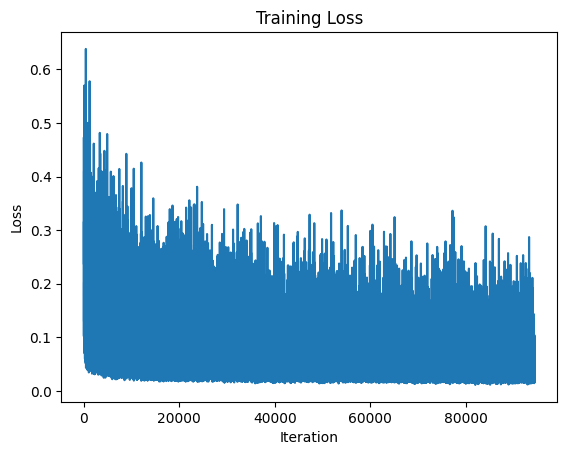

In [33]:
epoch_loss = 0
cnt = 0


# loop over epochs with tqdm progress bar
t = trange(n_epochs, leave=True)
for epoch in t:
    # initialize the training and validation loss for this epoch
    train_loss_epoch = 0.0
    valid_loss_epoch = 0.0

    # set the model to training mode
    Net.train()


    # loop over the training data
    #### IMPORTANT ####
    # len(images) == 3, if we are in the small size, so perhaps we can
    # heuristically increase this in order to get better results
    # sinze now it's just 3 images per epoch
    for input, label in dataloader:
        # load the first image and label
        # print(' ------------ new batch --------------')
        # print("Input: " + str(input))
        # print("Label: " + str(label))

        input = input[0]
        label = label[0]

        exposure_input = float(((input.split('_'))[-1]).rstrip('s.ARW'))
        exposure_label = float(((label.split('_'))[-1]).rstrip('s.ARW'))
        ratio = min(exposure_label / exposure_label, 300)


        #image = rawpy.imread(input)
        image = functions.pack_raw_sony(rawpy.imread(input)) * ratio
        #image = np.expand_dims(image, axis=0)
        label = rawpy.imread(label)

        # convert the image and label to numpy arrays
        #image = image.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)
        label = label.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)

        # convert the image and label to float32 data type
        #image = np.float32(image / 65535.0)
        label = np.float32(label / 65535.0)
        #label = np.expand_dims(label, axis=0)

        # strip input and label from paranthese
        # if cnt % 20 == 0:
        #     # display the image and label
        #     # print("Input:")
        #     # plt.imshow(image)
        #     # plt.show()
        #     print("Label:")
        #     plt.imshow(label)
        #     plt.show()


        ####### POSTPROCESSING #######

        # crop the image and label to 512 x 512
        image, label = functions.random_crop(image, label, patch_size)

        # if cnt % 20 == 0:
        #     # display the image and label
        #     # print("Input patch:")
        #     # plt.imshow(image)
        #     # plt.show()
        #     print("Label patch:")
        #     plt.imshow(label)
        #     plt.show()

        # convert the image and label to tensors
        image = torch.from_numpy(np.expand_dims(np.transpose(image, (2, 0, 1)), axis=0))
        label = torch.from_numpy(np.expand_dims(np.transpose(label, (2, 0, 1)), axis=0))

        # move the image and label to the device
        image, label = image.to(device), label.to(device)

        # forward pass
        output = Net(image)

        # calculate the loss
        loss = loss_function(output, label)

        if cnt % 20 == 0:
            # # also display the input patch
            # # print("Label:")
            label_image = label[0].cpu().detach().numpy().transpose(1, 2, 0)
            # # plt.imshow(label_image)
            # # plt.show()
            # print("Output:")
            output_image = output[0].cpu().detach().numpy().transpose(1, 2, 0)
            output_image = np.minimum(np.maximum(output_image, 0), 1)
            output_image = np.concatenate((label_image, output_image), axis=1)
            # #output_image[:, :, [0, 1]] = output_image[:, :, [1, 0]]
            # plt.imshow(output_image)
            # plt.show()
            # print(f"Loss: {loss.item()}")

            if not os.path.isdir(result_dir + '%04d' % epoch):
                os.makedirs(result_dir + '%04d' % epoch)
            functions.toimage(output_image * 255, high=255, low=0, cmin=0, cmax=255).save(
                result_dir + '%04d/%05d_' % (epoch, ratio) + str(os.path.basename(input)[:-3]) + 'jpg')
            

        # backward pass
        loss.backward()

        # update the weights
        optimizer.step()

        # clear the gradients
        optimizer.zero_grad()

        # print the loss
        # print("==> Loss: {}".format(loss.item()))
        epoch_loss = loss.item()

        # update the training loss
        train_loss_epoch += loss.item()

        # append loss to the list
        train_loss.append(loss.item())

        cnt = cnt + 1 
            # save state of network every 5 epochs
    if epoch % 5 == 0:
        savedir = 'saved_models/'
        if not os.path.isdir(savedir):
            os.makedirs(savedir)
        torch.save(Net.state_dict(), savedir + 'model_epoch_' + str(epoch) + '.pth')
        print('model saved at epoch {}'.format(epoch))
        

# plot loss
plt.plot(train_loss)
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

# plot

Model's state_dict:
e1.conv.conv1.weight 	 torch.Size([32, 4, 3, 3])
e1.conv.conv1.bias 	 torch.Size([32])
e1.conv.bn1.weight 	 torch.Size([32])
e1.conv.bn1.bias 	 torch.Size([32])
e1.conv.bn1.running_mean 	 torch.Size([32])
e1.conv.bn1.running_var 	 torch.Size([32])
e1.conv.bn1.num_batches_tracked 	 torch.Size([])
e1.conv.conv2.weight 	 torch.Size([32, 32, 3, 3])
e1.conv.conv2.bias 	 torch.Size([32])
e1.conv.bn2.weight 	 torch.Size([32])
e1.conv.bn2.bias 	 torch.Size([32])
e1.conv.bn2.running_mean 	 torch.Size([32])
e1.conv.bn2.running_var 	 torch.Size([32])
e1.conv.bn2.num_batches_tracked 	 torch.Size([])
e2.conv.conv1.weight 	 torch.Size([64, 32, 3, 3])
e2.conv.conv1.bias 	 torch.Size([64])
e2.conv.bn1.weight 	 torch.Size([64])
e2.conv.bn1.bias 	 torch.Size([64])
e2.conv.bn1.running_mean 	 torch.Size([64])
e2.conv.bn1.running_var 	 torch.Size([64])
e2.conv.bn1.num_batches_tracked 	 torch.Size([])
e2.conv.conv2.weight 	 torch.Size([64, 64, 3, 3])
e2.conv.conv2.bias 	 torch.Size([64])

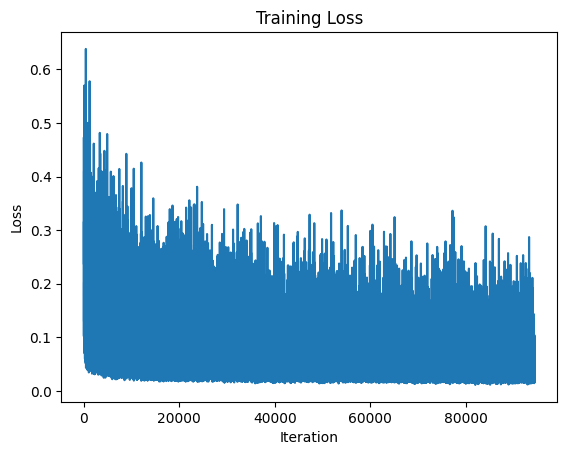

In [34]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in Net.state_dict():
    print(param_tensor, "\t", Net.state_dict()[param_tensor].size())

plt.plot(train_loss)
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

checkpoint_dir = "checkpoints_private"
if not os.path.isdir(checkpoint_dir):
                os.makedirs(checkpoint_dir)

torch.save(Net.state_dict(), "checkpoints_private/2023_03_30.pt")